In [2]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os


In [ ]:
dataset = "/content/drive/My Drive/tensorflow.keras-VGG16/dataset"
plot = "/content/drive/My Drive/tensorflow.keras-VGG16/plot.png" 
model_path = "/content/drive/My Drive/tensorflow.keras-VGG16/trained.model"

args={} 
args["dataset"]=dataset 
args["plot"]=plot 
args["model"]=model_path


In [5]:
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")
#imagePaths = list(paths.list_images(args["dataset"]))
imagePaths = list(paths.list_images(dataset))
data = []
labels = []
# loop over the image paths
for imagePath in imagePaths:
  # extract the class label from the filename
  label = imagePath.split(os.path.sep)[-2]
  # load the image, swap color channels, and resize it to be a fixed
  # 224x224 pixels while ignoring aspect ratio
  image = cv2.imread(imagePath)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image, (224, 224))
  # update the data and labels lists, respectively
  data.append(image)
  labels.append(label)
# convert the data and labels to NumPy arrays while scaling the pixel
# intensities to the range [0, 1]
data = np.array(data) / 255.0
labels = np.array(labels)


[INFO] loading images...


In [ ]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels); # print(labels)


In [ ]:
# partition the data into training and validating splits using 80% of
# the data for training and the remaining 20% for validating
(trainX, valX, trainY, valY) = train_test_split(data, labels,
  test_size=0.20, stratify=labels, random_state=42)
# initialize the training data augmentation object
trainAug = ImageDataGenerator(
  rotation_range=15,
  fill_mode="nearest")


In [ ]:
# load the VGG16 network, ensuring the head FC layer sets are left
# off
baseModel = VGG16(weights="imagenet", include_top=False,
  input_tensor=Input(shape=(224, 224, 3)))
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
  layer.trainable = False


In [ ]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-3
EPOCHS = 50
BS = 10


In [12]:
# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
  metrics=["accuracy"])
# train the head of the network
print("[INFO] training head...")
H = model.fit_generator(
  trainAug.flow(trainX, trainY, batch_size=BS),
  steps_per_epoch=len(trainX) // BS,
  validation_data=(valX, valY),
  validation_steps=len(valX) // BS,
  epochs=EPOCHS)


[INFO] compiling model...
[INFO] training head...
Epoch 1/50
4/4 [==============================] - 20s 5s/step - loss: 0.8543 - accuracy: 0.4000 - val_loss: 0.6785 - val_accuracy: 0.5000
Epoch 2/50
4/4 [==============================] - 20s 5s/step - loss: 0.5946 - accuracy: 0.7250 - val_loss: 0.6281 - val_accuracy: 0.7000
Epoch 3/50
4/4 [==============================] - 20s 5s/step - loss: 0.6467 - accuracy: 0.6500 - val_loss: 0.6068 - val_accuracy: 0.7000
Epoch 4/50
4/4 [==============================] - 20s 5s/step - loss: 0.5884 - accuracy: 0.7250 - val_loss: 0.5858 - val_accuracy: 0.7000
Epoch 5/50
4/4 [==============================] - 20s 5s/step - loss: 0.6600 - accuracy: 0.5250 - val_loss: 0.5594 - val_accuracy: 0.9000
Epoch 6/50
4/4 [==============================] - 20s 5s/step - loss: 0.4753 - accuracy: 0.8250 - val_loss: 0.5399 - val_accuracy: 0.9000
Epoch 7/50
4/4 [==============================] - 20s 5s/step - loss: 0.4671 - accuracy: 0.7750 - val_loss: 0.5200 - val_a

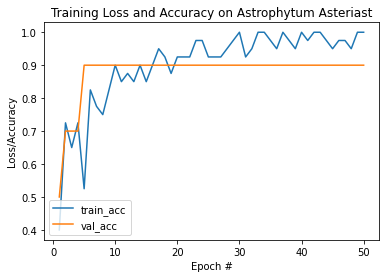

In [13]:
# plot the training loss and accuracy
N = EPOCHS
#plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0.99, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0.99, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Astrophytum Asteriast")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
#plt.savefig(args["plot"])
plt.savefig(plot)


In [14]:
# serialize the model to disk
print("[INFO] saving trained model...")
# model.save(args["model"], save_format="h5")
model.save(model_path, save_format="h5")


[INFO] saving trained model...


In [15]:
image_unknow = cv2.imread("/content/drive/My Drive/tensorflow.keras-VGG16/unknown_sample/1-1.jpg")
image_unknow = cv2.cvtColor(image_unknow, cv2.COLOR_BGR2RGB)
image_unknow = cv2.resize(image_unknow, (224, 224)) # size of picture = [224, 224, 3]
data = [image_unknow] # size of picture arrays = [1, 224, 224, 3]
data = np.array(data) / 255.0

predIdxs = model.predict(data, batch_size=1)
result = np.argmax(predIdxs, axis=1)

if result == 0:
  print("not astrophytum asterias")
if result == 1:
  print("astrophytum asterias")


astrophytum asterias


In [16]:
image_unknow = cv2.imread("/content/drive/My Drive/tensorflow.keras-VGG16/unknown_sample/2-1.jpg")
image_unknow = cv2.cvtColor(image_unknow, cv2.COLOR_BGR2RGB)
image_unknow = cv2.resize(image_unknow, (224, 224)) # size of picture = [224, 224, 3]
data = [image_unknow] # size of picture arrays = [1, 224, 224, 3]
data = np.array(data) / 255.0

predIdxs = model.predict(data, batch_size=1)
result = np.argmax(predIdxs, axis=1)

if result == 0:
  print("not astrophytum asterias")
if result == 1:
  print("astrophytum asterias")


astrophytum asterias


In [17]:
image_unknow = cv2.imread("/content/drive/My Drive/tensorflow.keras-VGG16/unknown_sample/3-1.jpg")
image_unknow = cv2.cvtColor(image_unknow, cv2.COLOR_BGR2RGB)
image_unknow = cv2.resize(image_unknow, (224, 224)) # size of picture = [224, 224, 3]
data = [image_unknow] # size of picture arrays = [1, 224, 224, 3]
data = np.array(data) / 255.0

predIdxs = model.predict(data, batch_size=1)
result = np.argmax(predIdxs, axis=1)

if result == 0:
  print("not astrophytum asterias")
if result == 1:
  print("astrophytum asterias")

astrophytum asterias


In [18]:
image_unknow = cv2.imread("/content/drive/My Drive/tensorflow.keras-VGG16/unknown_sample/4-1.jpg")
image_unknow = cv2.cvtColor(image_unknow, cv2.COLOR_BGR2RGB)
image_unknow = cv2.resize(image_unknow, (224, 224)) # size of picture = [224, 224, 3]
data = [image_unknow] # size of picture arrays = [1, 224, 224, 3]
data = np.array(data) / 255.0

predIdxs = model.predict(data, batch_size=1)
result = np.argmax(predIdxs, axis=1)

if result == 0:
  print("not astrophytum asterias")
if result == 1:
  print("astrophytum asterias")

astrophytum asterias


In [19]:
image_unknow = cv2.imread("/content/drive/My Drive/tensorflow.keras-VGG16/unknown_sample/5-0.jpg")
image_unknow = cv2.cvtColor(image_unknow, cv2.COLOR_BGR2RGB)
image_unknow = cv2.resize(image_unknow, (224, 224)) # size of picture = [224, 224, 3]
data = [image_unknow] # size of picture arrays = [1, 224, 224, 3]
data = np.array(data) / 255.0

predIdxs = model.predict(data, batch_size=1)
result = np.argmax(predIdxs, axis=1)

if result == 0:
  print("not astrophytum asterias")
if result == 1:
  print("astrophytum asterias")

not astrophytum asterias


In [20]:
image_unknow = cv2.imread("/content/drive/My Drive/tensorflow.keras-VGG16/unknown_sample/6-0.jpg")
image_unknow = cv2.cvtColor(image_unknow, cv2.COLOR_BGR2RGB)
image_unknow = cv2.resize(image_unknow, (224, 224)) # size of picture = [224, 224, 3]
data = [image_unknow] # size of picture arrays = [1, 224, 224, 3]
data = np.array(data) / 255.0

predIdxs = model.predict(data, batch_size=1)
result = np.argmax(predIdxs, axis=1)

if result == 0:
  print("not astrophytum asterias")
if result == 1:
  print("astrophytum asterias")

not astrophytum asterias


In [21]:
image_unknow = cv2.imread("/content/drive/My Drive/tensorflow.keras-VGG16/unknown_sample/7-0.jpg")
image_unknow = cv2.cvtColor(image_unknow, cv2.COLOR_BGR2RGB)
image_unknow = cv2.resize(image_unknow, (224, 224)) # size of picture = [224, 224, 3]
data = [image_unknow] # size of picture arrays = [1, 224, 224, 3]
data = np.array(data) / 255.0

predIdxs = model.predict(data, batch_size=1)
result = np.argmax(predIdxs, axis=1)

if result == 0:
  print("not astrophytum asterias")
if result == 1:
  print("astrophytum asterias")

not astrophytum asterias


In [22]:
image_unknow = cv2.imread("/content/drive/My Drive/tensorflow.keras-VGG16/unknown_sample/8-0.jpg")
image_unknow = cv2.cvtColor(image_unknow, cv2.COLOR_BGR2RGB)
image_unknow = cv2.resize(image_unknow, (224, 224)) # size of picture = [224, 224, 3]
data = [image_unknow] # size of picture arrays = [1, 224, 224, 3]
data = np.array(data) / 255.0

predIdxs = model.predict(data, batch_size=1)
result = np.argmax(predIdxs, axis=1)

if result == 0:
  print("not astrophytum asterias")
if result == 1:
  print("astrophytum asterias")

not astrophytum asterias


In [23]:
image_unknow = cv2.imread("/content/drive/My Drive/tensorflow.keras-VGG16/unknown_sample/Hybrid-0.jpg")
image_unknow = cv2.cvtColor(image_unknow, cv2.COLOR_BGR2RGB)
image_unknow = cv2.resize(image_unknow, (224, 224)) # size of picture = [224, 224, 3]
data = [image_unknow] # size of picture arrays = [1, 224, 224, 3]
data = np.array(data) / 255.0

predIdxs = model.predict(data, batch_size=1)
result = np.argmax(predIdxs, axis=1)

if result == 0:
  print("not astrophytum asterias")
if result == 1:
  print("astrophytum asterias")

not astrophytum asterias
